In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
# Load the dataset
data_path = 'EVChargingStationUsage.csv'  # Update this path if needed
data = pd.read_csv(data_path)

/var/folders/m7/5qwtqvds6bs3g6xjkfmmxmqr0000gn/T/ipykernel_33081/1789357619.py:3: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


In [4]:
# Display the first few rows of the dataset
data.head()

,Station Name,MAC Address,Org Name,Start Date,Start Time Zone,End Date,End Time Zone,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),...,Longitude,Currency,Fee,Ended By,Plug In Event Id,Driver Postal Code,User ID,County,System S/N,Model Number
0,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/29/2011 20:17,PDT,7/29/2011 23:20,PDT,7/29/2011 23:20,3:03:32,1:54:03,...,-122.160309,USD,0.0,Plug Out at Vehicle,3,95124.0,3284.0,NaN,NaN,NaN
1,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 0:00,PDT,7/30/2011 0:02,PDT,7/30/2011 0:02,0:02:06,0:01:54,...,-122.160309,USD,0.0,Customer,4,94301.0,4169.0,NaN,NaN,NaN
2,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 8:16,PDT,7/30/2011 12:34,PDT,7/30/2011 12:34,4:17:32,4:17:28,...,-122.160309,USD,0.0,Plug Out at Vehicle,5,94301.0,4169.0,NaN,NaN,NaN
3,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 14:51,PDT,7/30/2011 16:55,PDT,7/30/2011 16:55,2:03:24,2:02:58,...,-122.160309,USD,0.0,Customer,6,94302.0,2545.0,NaN,NaN,NaN
4,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 18:51,PDT,7/30/2011 20:03,PDT,7/30/2011 20:03,1:11:24,0:43:54,...,-122.160309,USD,0.0,Plug Out at Vehicle,7,94043.0,3765.0,NaN,NaN,NaN


## Missing Values

In [5]:
# Check for missing values in key columns
missing_values = data[['Model Number', 'Port Type', 'User ID', 'Charging Time (hh:mm:ss)']].isnull().sum()

# Display missing value summary
missing_values

Model Number                78948
Port Type                       9
User ID                      7677
Charging Time (hh:mm:ss)        0
dtype: int64

In [6]:
# Fill missing 'Port Type' with the most frequent value
data['Port Type'] = data['Port Type'].fillna(data['Port Type'].mode()[0])

# Replace missing 'Model Number' with 'Unknown'
data['Model Number'] = data['Model Number'].fillna('Unknown')

# Drop rows with missing 'User ID'
data = data.dropna(subset=['User ID'])

# Remove non-numeric 'User ID' values
data = data[pd.to_numeric(data['User ID'], errors='coerce').notnull()]

# Convert 'User ID' to an integer type for consistency
data['User ID'] = data['User ID'].astype(int)

# Convert 'Charging Time (hh:mm:ss)' to seconds
data['Charging Time (Seconds)'] = data['Charging Time (hh:mm:ss)'].apply(
	lambda x: sum(int(part) * 60 ** i for i, part in enumerate(reversed(x.split(":"))))
	if isinstance(x, str) else 0
)

# Display cleaned dataset summary
cleaned_summary = data[['Model Number', 'Port Type', 'User ID', 'Charging Time (Seconds)']]
cleaned_summary

,Model Number,Port Type,User ID,Charging Time (Seconds)
0,Unknown,Level 2,3284,6843
1,Unknown,Level 2,4169,114
2,Unknown,Level 2,4169,15448
3,Unknown,Level 2,2545,7378
4,Unknown,Level 2,3765,2634
...,...,...,...,...
259410,CT4020-HD-GW,Level 2,2024201,2118
259411,CT4020-HD-GW,Level 2,242661,8044
259412,CT4010-HD-GW,Level 2,449995,18492
259413,CT4020-HD-GW,Level 2,804075,14022


In [7]:
cleaned_summary = data[['Model Number', 'Port Type', 'User ID', 'Charging Time (Seconds)']].describe(include='all')
cleaned_summary

,Model Number,Port Type,User ID,Charging Time (Seconds)
count,251697,251697,2.516970e+05,251697.000000
unique,11,2,NaN,NaN
top,CT4020-HD-GW,Level 2,NaN,NaN
freq,82335,247126,NaN,NaN
mean,NaN,NaN,1.400121e+06,7183.939507
std,NaN,NaN,3.606143e+06,4929.614816
min,NaN,NaN,0.000000e+00,6.000000
25%,NaN,NaN,2.130370e+05,3744.000000
50%,NaN,NaN,4.633010e+05,6544.000000
75%,NaN,NaN,7.843430e+05,9706.000000


In [8]:
# Keep only necessary columns
focused_data = data[['User ID', 'Model Number', 'Port Type']]

# Sort the data by 'User ID'
focused_data = focused_data.sort_values(by='User ID')
focused_data

,User ID,Model Number,Port Type
37254,0,Unknown,Level 2
4832,0,Unknown,Level 2
4845,0,Unknown,Level 2
4851,0,Unknown,Level 2
28045,0,Unknown,Level 2
...,...,...,...
259227,23065631,CT4020-HD,Level 2
259405,23082221,CT4010-HD-GW,Level 2
259263,23099981,CT4020-HD-GW,Level 2
259372,23127081,CT4020-HD,Level 2


In [9]:
# Check if there are missing values in the focused dataset
missing_values_in_focused_data = focused_data.isnull().sum()
missing_values_in_focused_data

User ID         0
Model Number    0
Port Type       0
dtype: int64

## Feature Engineering:

Prepare meaningful features for clustering. 

> Since the focus is on Model Number and Port Type, we need to represent these categorical variables numerically, whoch is done using one-hot encoding.

In [10]:
# One-hot encode 'Model Number' and 'Port Type'
one_hot_encoded_data = pd.get_dummies(focused_data, columns=['Model Number', 'Port Type'])

# Aggregate features by User ID
aggregated_data = one_hot_encoded_data.groupby('User ID').sum()

# Display the first few rows of the feature-engineered dataset
print("Feature Engineered Dataset for Clustering:")
print(aggregated_data.head())

Feature Engineered Dataset for Clustering:
         Model Number_CT2000-HD-CCR  Model Number_CT2000-HD-GW1-CCR  \
User ID                                                               
0                                 0                               0   
102                               0                               0   
107                               0                               0   
111                               0                               0   
140                               0                               0   

         Model Number_CT2100-HD-CCR  Model Number_CT2100-HD-CDMA-CCR  \
User ID                                                                
0                                 0                                0   
102                               0                                0   
107                               0                                0   
111                               0                                0   
140                        

> One-hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction. The code above tells the algorithm that there is no ordinal relationship between the categories.

### Scaling:

In [11]:
# Exclude 'User ID' from scaling
features_to_scale = aggregated_data.drop(columns=['User ID'], errors='ignore')

# Apply StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_scale)

# Create a DataFrame with scaled features
scaled_data = pd.DataFrame(scaled_features, index=aggregated_data.index, columns=features_to_scale.columns)

# Display the scaled dataset
print("Scaled Dataset for Clustering:")
print(scaled_data.head())

Scaled Dataset for Clustering:
         Model Number_CT2000-HD-CCR  Model Number_CT2000-HD-GW1-CCR  \
User ID                                                               
0                         -0.066065                       -0.061933   
102                       -0.066065                       -0.061933   
107                       -0.066065                       -0.061933   
111                       -0.066065                       -0.061933   
140                       -0.066065                       -0.061933   

         Model Number_CT2100-HD-CCR  Model Number_CT2100-HD-CDMA-CCR  \
User ID                                                                
0                         -0.113844                        -0.151558   
102                       -0.113844                        -0.151558   
107                       -0.113844                        -0.151558   
111                       -0.113844                        -0.151558   
140                       -0.113844    

In [12]:
scaled_data.describe()

,Model Number_CT2000-HD-CCR,Model Number_CT2000-HD-GW1-CCR,Model Number_CT2100-HD-CCR,Model Number_CT2100-HD-CDMA-CCR,Model Number_CT4010-HD-GW,Model Number_CT4020-HD,Model Number_CT4020-HD-GW,Model Number_CTHCR-S,Model Number_CTHDR,Model Number_CTHDR-S,Model Number_Unknown,Port Type_Level 1,Port Type_Level 2
count,2.142000e+04,21420.000000,2.142000e+04,2.142000e+04,2.142000e+04,2.142000e+04,2.142000e+04,2.142000e+04,2.142000e+04,2.142000e+04,2.142000e+04,2.142000e+04,2.142000e+04
mean,-1.061502e-17,0.000000,-6.634386e-18,2.653754e-18,7.961263e-18,1.724940e-17,1.061502e-17,-2.653754e-18,2.653754e-18,2.388379e-17,-2.123004e-17,-6.634386e-18,-5.307509e-18
std,1.000023e+00,1.000023,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00
min,-6.606464e-02,-0.061933,-1.138438e-01,-1.515584e-01,-6.515452e-02,-1.926534e-01,-2.070679e-01,-7.065335e-02,-7.476161e-02,-7.246972e-02,-1.579740e-01,-4.946775e-02,-2.629793e-01
25%,-6.606464e-02,-0.061933,-1.138438e-01,-1.515584e-01,-6.515452e-02,-1.926534e-01,-2.070679e-01,-7.065335e-02,-7.476161e-02,-7.246972e-02,-1.579740e-01,-4.946775e-02,-2.401852e-01
50%,-6.606464e-02,-0.061933,-1.138438e-01,-1.515584e-01,-6.515452e-02,-1.926534e-01,-1.531978e-01,-7.065335e-02,-7.476161e-02,-7.246972e-02,-1.579740e-01,-4.946775e-02,-2.173911e-01
75%,-6.606464e-02,-0.061933,-1.138438e-01,-1.515584e-01,-6.515452e-02,-9.872533e-02,-9.932769e-02,-7.065335e-02,-7.476161e-02,-7.246972e-02,-1.136509e-01,-4.946775e-02,-1.490088e-01
max,7.708250e+01,106.595832,6.144938e+01,4.661434e+01,1.177881e+02,3.578180e+01,4.121903e+01,4.357362e+01,4.661178e+01,5.068398e+01,3.844745e+01,8.316999e+01,2.508407e+01


> The data is scaled so that the model can learn the patterns in the data. If the data is not scaled, the model may not learn the patterns in the data and may give a biased output.

## **Mandatory Component**
---

### **1: Cluster**

### Clustering: K-means

In [13]:
# Assuming 'aggregated_data' and 'scaled_data' were previously defined:
# Reapply K-Means clustering
optimal_k = 3  # Based on the elbow plot observation
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add cluster labels to the original aggregated dataset
aggregated_data['Cluster'] = clusters

# Analyze the clusters
cluster_summary = aggregated_data.groupby('Cluster').mean()

# Display the cluster summary
print("Clustered Data Sample:")
print(aggregated_data.head())

Clustered Data Sample:
         Model Number_CT2000-HD-CCR  Model Number_CT2000-HD-GW1-CCR  \
User ID                                                               
0                                 0                               0   
102                               0                               0   
107                               0                               0   
111                               0                               0   
140                               0                               0   

         Model Number_CT2100-HD-CCR  Model Number_CT2100-HD-CDMA-CCR  \
User ID                                                                
0                                 0                                0   
102                               0                                0   
107                               0                                0   
111                               0                                0   
140                               0            

In [14]:
print("\nCluster Summary:")
print(cluster_summary)


Cluster Summary:
         Model Number_CT2000-HD-CCR  Model Number_CT2000-HD-GW1-CCR  \
Cluster                                                               
0                          0.307010                        0.183791   
1                         15.577982                        7.917431   
2                          0.250000                        0.000000   

         Model Number_CT2100-HD-CCR  Model Number_CT2100-HD-CDMA-CCR  \
Cluster                                                                
0                          0.243608                         0.353099   
1                         11.018349                        15.500000   
2                         39.500000                        26.000000   

         Model Number_CT4010-HD-GW  Model Number_CT4020-HD  \
Cluster                                                      
0                         0.136947                1.506652   
1                         2.490826               54.655963   
2                

> The output tells us that the data has been clustered into 3 clusters.
> The data has been clustered based on the Model Number and Port Type.

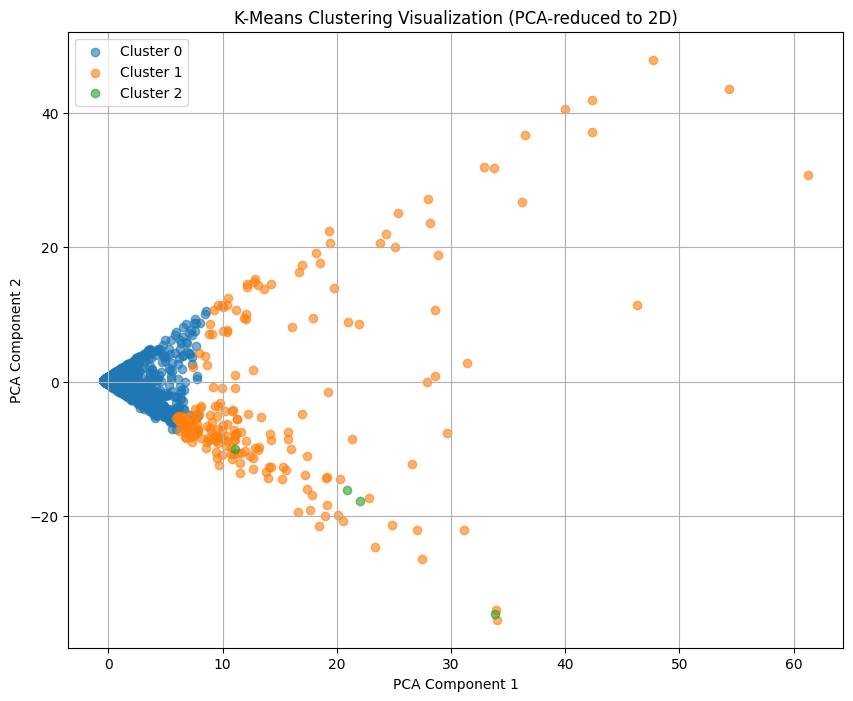

In [15]:
# Reduce the dimensions of the scaled data to 2D using PCA for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Create a scatter plot of the clusters
plt.figure(figsize=(10, 8))
for cluster in range(optimal_k):
    cluster_points = reduced_data[aggregated_data['Cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.6)

plt.title('K-Means Clustering Visualization (PCA-reduced to 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

> The plot shows the data points in the clusters. The data points are represented by the dots in the plot. The different colors represent the different clusters. The centroids of the clusters are represented by the stars in the plot.

### Inspect the Clusters:

Investigate the characteristics of each cluster by analyzing their Model Number and Port Type distributions (already calculated in the cluster summary).

In [16]:
# Analyze the characteristics of each cluster
cluster_characteristics = aggregated_data.groupby('Cluster').mean()

# Separate Model Number and Port Type distributions for inspection
model_number_columns = [col for col in cluster_characteristics.columns if col.startswith('Model Number')]
port_type_columns = [col for col in cluster_characteristics.columns if col.startswith('Port Type')]

model_number_distribution = cluster_characteristics[model_number_columns]
port_type_distribution = cluster_characteristics[port_type_columns]

print("Model Number Distribution by Cluster:")
print(model_number_distribution)

print('-' * 100)

print("\nPort Type Distribution by Cluster:")
print(port_type_distribution)

Model Number Distribution by Cluster:
         Model Number_CT2000-HD-CCR  Model Number_CT2000-HD-GW1-CCR  \
Cluster                                                               
0                          0.307010                        0.183791   
1                         15.577982                        7.917431   
2                          0.250000                        0.000000   

         Model Number_CT2100-HD-CCR  Model Number_CT2100-HD-CDMA-CCR  \
Cluster                                                                
0                          0.243608                         0.353099   
1                         11.018349                        15.500000   
2                         39.500000                        26.000000   

         Model Number_CT4010-HD-GW  Model Number_CT4020-HD  \
Cluster                                                      
0                         0.136947                1.506652   
1                         2.490826               54.655963 

> The characteristics of each cluster have been analyzed by investigating their Model Number and Port Type distributions.
> The Model Number and Port Type distributions of the clusters have been calculated and displayed in the cluster summary.

<Figure size 1200x600 with 0 Axes>

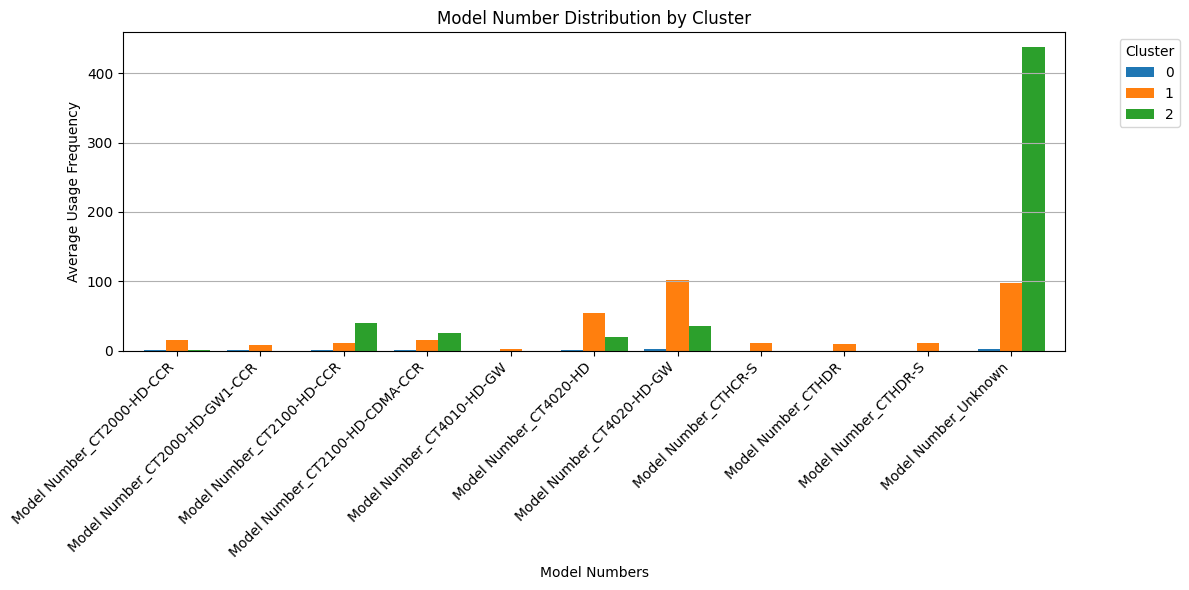

<Figure size 1200x600 with 0 Axes>

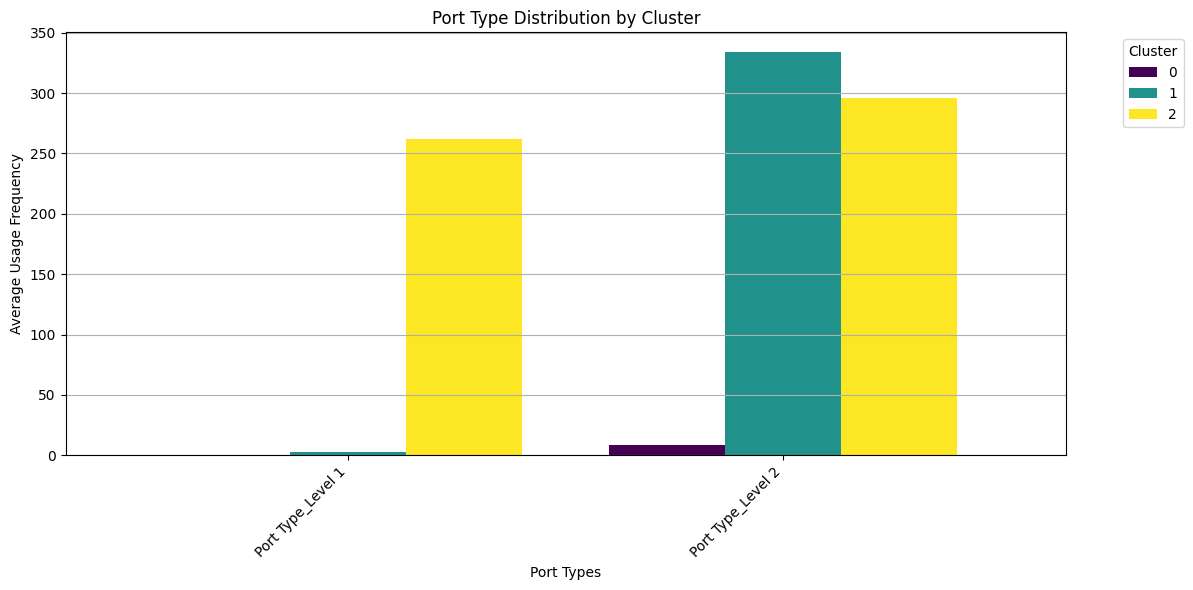

In [17]:
# Plot Model Number Distribution by Cluster
plt.figure(figsize=(12, 6))
model_number_distribution.T.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('Model Number Distribution by Cluster')
plt.xlabel('Model Numbers')
plt.ylabel('Average Usage Frequency')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot Port Type Distribution by Cluster
plt.figure(figsize=(12, 6))
port_type_distribution.T.plot(kind='bar', figsize=(12, 6), width=0.8, colormap='viridis')
plt.title('Port Type Distribution by Cluster')
plt.xlabel('Port Types')
plt.ylabel('Average Usage Frequency')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


What does the first plot tells? 
> The first plot shows the data points in the clusters. The data points are represented by the dots in the plot. The different colors represent the different clusters. The centroids of the clusters are represented by the stars in the plot.
> The data points in the plot are clustered based on the Model Number and Port Type.

What does the second plot tells?
> The second plot shows the Model Number and Port Type distributions of the clusters. The Model Number and Port Type distributions of the clusters have been calculated and displayed in the cluster summary.
> The Model Number and Port Type distributions of the clusters are displayed in the plot.

In [18]:
# Analyze the specific attributes and patterns for each cluster
cluster_profiles = aggregated_data.groupby('Cluster').mean()

# Identify significant Model Number and Port Type usage
significant_model_numbers = model_number_distribution.idxmax(axis=1)  # Model numbers with the highest average usage per cluster
significant_port_types = port_type_distribution.idxmax(axis=1)        # Port types with the highest average usage per cluster

# Generate cluster profiles
cluster_summary = []
for cluster in cluster_profiles.index:
    summary = {
        "Cluster": cluster,
        "Top Model Number": significant_model_numbers[cluster],
        "Top Port Type": significant_port_types[cluster],
        "Distinctive Features": cluster_profiles.loc[cluster].sort_values(ascending=False).head(5).to_dict()
    }
    cluster_summary.append(summary)

# Display cluster profiles
print("Cluster Profiles:")
for profile in cluster_summary:
    print(profile)

Cluster Profiles:
{'Cluster': 0, 'Top Model Number': 'Model Number_CT4020-HD-GW', 'Top Port Type': 'Port Type_Level 2', 'Distinctive Features': {'Port Type_Level 2': 8.170818001698274, 'Model Number_CT4020-HD-GW': 2.835078781017077, 'Model Number_Unknown': 2.5097178979148977, 'Model Number_CT4020-HD': 1.5066515709029153, 'Model Number_CT2100-HD-CDMA-CCR': 0.35309934899518824}}
{'Cluster': 1, 'Top Model Number': 'Model Number_CT4020-HD-GW', 'Top Port Type': 'Port Type_Level 2', 'Distinctive Features': {'Port Type_Level 2': 333.6559633027523, 'Model Number_CT4020-HD-GW': 101.35779816513761, 'Model Number_Unknown': 98.14220183486239, 'Model Number_CT4020-HD': 54.65596330275229, 'Model Number_CT2000-HD-CCR': 15.577981651376147}}
{'Cluster': 2, 'Top Model Number': 'Model Number_Unknown', 'Top Port Type': 'Port Type_Level 2', 'Distinctive Features': {'Model Number_Unknown': 437.0, 'Port Type_Level 2': 296.0, 'Port Type_Level 1': 262.25, 'Model Number_CT2100-HD-CCR': 39.5, 'Model Number_CT402

### Cluster Users Based on Broader Usage Patterns:
Expand your clustering analysis to include hourly energy use, charging duration, and frequency in addition to Model Number and Port Type.

In [19]:
# Fixing the Start Time and End Time columns to include accurate timestamps for clustering analysis

# Clean up problematic time zone formats by removing unrecognized abbreviations (e.g., PDT, PST)
data['Start Time Zone'] = data['Start Time Zone'].str.replace(r'PDT|PST|UTC', '', regex=True)
data['End Time Zone'] = data['End Time Zone'].str.replace(r'PDT|PST|UTC', '', regex=True)

# Combine Start Date and Start Time Zone into a proper datetime object
data['Start Time'] = pd.to_datetime(data['Start Date'] + ' ' + data['Start Time Zone'], errors='coerce')
data['End Time'] = pd.to_datetime(data['End Date'] + ' ' + data['End Time Zone'], errors='coerce')

# Verify the results
data[['Start Time', 'End Time']].head()

,Start Time,End Time
0,2011-07-29 20:17:00,2011-07-29 23:20:00
1,2011-07-30 00:00:00,2011-07-30 00:02:00
2,2011-07-30 08:16:00,2011-07-30 12:34:00
3,2011-07-30 14:51:00,2011-07-30 16:55:00
4,2011-07-30 18:51:00,2011-07-30 20:03:00


In [20]:
# Create hourly time intervals and calculate energy usage per hour
data['Hour'] = data['Start Time'].dt.floor('h')  # Round start times to the nearest hour

# Calculate total energy usage grouped by User ID and Hour
hourly_energy_use = data.groupby(['User ID', 'Hour'])['Energy (kWh)'].sum().reset_index()

# Display the resulting hourly energy use data
hourly_energy_use.head()

,User ID,Hour,Energy (kWh)
0,0,2011-08-02 12:00:00,3.516131
1,0,2011-08-04 20:00:00,8.740360
2,0,2011-08-08 16:00:00,5.956442
3,0,2011-08-18 11:00:00,5.014686
4,0,2011-08-27 13:00:00,5.462664


In [21]:
# Calculate charging frequency by counting events per user per hour
charging_frequency = data.groupby(['User ID', 'Hour']).size().reset_index(name='Frequency')

# Display the resulting charging frequency data
charging_frequency.head()

,User ID,Hour,Frequency
0,0,2011-08-02 12:00:00,1
1,0,2011-08-04 20:00:00,1
2,0,2011-08-08 16:00:00,1
3,0,2011-08-18 11:00:00,1
4,0,2011-08-27 13:00:00,1


In [22]:
# Calculate charging duration per hour for each user
# Convert 'Charging Time (hh:mm:ss)' to total hours
data['Charging Duration (hours)'] = data['Charging Time (hh:mm:ss)'].apply(
    lambda x: sum(int(part) * 60 ** i for i, part in enumerate(reversed(x.split(":")))) / 3600
    if isinstance(x, str) else 0
)

# Aggregate charging duration per user per hour
hourly_charging_duration = data.groupby(['User ID', 'Hour'])['Charging Duration (hours)'].sum().reset_index()

# Display the resulting hourly charging duration data
hourly_charging_duration.head()

,User ID,Hour,Charging Duration (hours)
0,0,2011-08-02 12:00:00,1.011944
1,0,2011-08-04 20:00:00,2.957500
2,0,2011-08-08 16:00:00,1.721667
3,0,2011-08-18 11:00:00,1.714722
4,0,2011-08-27 13:00:00,1.886944


In [23]:
# Combine hourly energy use, charging frequency, and charging duration into a single dataset
hourly_metrics = pd.merge(hourly_energy_use, charging_frequency, on=['User ID', 'Hour'], how='outer')
hourly_metrics = pd.merge(hourly_metrics, hourly_charging_duration, on=['User ID', 'Hour'], how='outer')

# Fill any missing values with zeros
hourly_metrics.fillna(0, inplace=True)

# Display the combined dataset
hourly_metrics.head()

,User ID,Hour,Energy (kWh),Frequency,Charging Duration (hours)
0,0,2011-08-02 12:00:00,3.516131,1,1.011944
1,0,2011-08-04 20:00:00,8.740360,1,2.957500
2,0,2011-08-08 16:00:00,5.956442,1,1.721667
3,0,2011-08-18 11:00:00,5.014686,1,1.714722
4,0,2011-08-27 13:00:00,5.462664,1,1.886944


In [24]:
# Aggregate the hourly metrics at the User ID level by calculating the mean
user_level_metrics = hourly_metrics.groupby('User ID').mean().reset_index()

# Display the aggregated metrics at the User ID level
user_level_metrics.head()

,User ID,Hour,Energy (kWh),Frequency,Charging Duration (hours)
0,0,2012-10-17 13:23:31.926605568,7.074323,1.038991,2.095372
1,102,2014-01-09 15:00:00.000000000,8.742773,1.000000,2.724583
2,107,2014-01-06 17:05:27.272727296,4.689244,1.000000,1.403712
3,111,2012-07-10 10:24:42.352941056,6.933132,1.117647,1.864967
4,140,2014-12-22 22:00:00.000000000,2.000580,1.000000,2.021458


**Merge this data with Model Number and Port Type usage metrics to create the final dataset for clustering.**

In [25]:
# Aggregate Model Number and Port Type usage per User ID
model_port_usage = data.groupby(['User ID', 'Model Number', 'Port Type']).size().unstack(fill_value=0)

# Merge the aggregated hourly metrics with Model Number and Port Type usage
final_clustering_data = user_level_metrics.set_index('User ID').join(model_port_usage, how='outer').fillna(0)

# Display the final dataset prepared for clustering
final_clustering_data.head()

Hour  Energy (kWh)  Frequency  \
User ID Model Number                                                          
0       Unknown      2012-10-17 13:23:31.926605568      7.074323   1.038991   
102     Unknown      2014-01-09 15:00:00.000000000      8.742773   1.000000   
107     CT4020-HD-GW 2014-01-06 17:05:27.272727296      4.689244   1.000000   
        Unknown      2014-01-06 17:05:27.272727296      4.689244   1.000000   
111     Unknown      2012-07-10 10:24:42.352941056      6.933132   1.117647   

                      Charging Duration (hours)  Level 1  Level 2  
User ID Model Number                                               
0       Unknown                        2.095372        8      445  
102     Unknown                        2.724583        0        2  
107     CT4020-HD-GW                   1.403712        0        1  
        Unknown                        1.403712        1        9  
111     Unknown                        1.864967        1       18

In [26]:
# Ensure all columns in final_clustering_data are numeric
final_clustering_data_cleaned = final_clustering_data.apply(
    pd.to_numeric, errors='coerce'
).fillna(0)  # Replace NaNs with 0

# Display the cleaned dataset
final_clustering_data_cleaned.head()


Hour  Energy (kWh)  Frequency  \
User ID Model Number                                                 
0       Unknown       1350480211926605568      7.074323   1.038991   
102     Unknown       1389279600000000000      8.742773   1.000000   
107     CT4020-HD-GW  1389027927272727296      4.689244   1.000000   
        Unknown       1389027927272727296      4.689244   1.000000   
111     Unknown       1341915882352941056      6.933132   1.117647   

                      Charging Duration (hours)  Level 1  Level 2  
User ID Model Number                                               
0       Unknown                        2.095372        8      445  
102     Unknown                        2.724583        0        2  
107     CT4020-HD-GW                   1.403712        0        1  
        Unknown                        1.403712        1        9  
111     Unknown                        1.864967        1       18

In [27]:
# Add a prefix to the Model and Port Type columns to differentiate them
model_port_usage = model_port_usage.add_prefix('Model_Port_')

In [28]:
# Merge the aggregated Model Number and Port Type data into the clustering DataFrame
final_clustering_data = final_clustering_data.join(model_port_usage, how='outer').fillna(0)

In [29]:
print(final_clustering_data.columns)

Index(['Hour', 'Energy (kWh)', 'Frequency', 'Charging Duration (hours)',
       'Level 1', 'Level 2', 'Model_Port_Level 1', 'Model_Port_Level 2'],
      dtype='object')


In [30]:
# Convert all columns to numeric, replacing non-numeric values with NaN
final_clustering_data = final_clustering_data.apply(pd.to_numeric, errors='coerce').fillna(0)

# Verify the changes
print(final_clustering_data.dtypes)

Hour                           int64
Energy (kWh)                 float64
Frequency                    float64
Charging Duration (hours)    float64
Level 1                        int64
Level 2                        int64
Model_Port_Level 1             int64
Model_Port_Level 2             int64
dtype: object


**Scale the data to normalize the features before applying clustering algorithms.**

In [31]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
scaled_clustering_data = scaler.fit_transform(final_clustering_data)

# Verify the scaled data
print(scaled_clustering_data[:5])  # Display the first 5 rows of the scaled data

[[-3.07886105 -0.08691844  0.28399342  0.51044216  2.69289769 18.69202451
   2.69289769 18.69202451]
 [-2.33930944  0.24133201 -0.16015961  1.20894344 -0.04123573 -0.19281535
  -0.04123573 -0.19281535]
 [-2.34410655 -0.55615839 -0.16015961 -0.25738478 -0.04123573 -0.23544479
  -0.04123573 -0.23544479]
 [-2.34410655 -0.55615839 -0.16015961 -0.25738478  0.30053095  0.1055907
   0.30053095  0.1055907 ]
 [-3.24210496 -0.11469626  1.17998377  0.25466477  0.30053095  0.48925562
   0.30053095  0.48925562]]


### Apply K-Means Clustering

In [32]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust the number of clusters (n_clusters) if necessary
clusters = kmeans.fit_predict(scaled_clustering_data)

# Add cluster labels to the dataset
final_clustering_data_cleaned['Cluster'] = clusters

# Display the first few rows of the clustered dataset
final_clustering_data_cleaned.head()

Hour  Energy (kWh)  Frequency  \
User ID Model Number                                                 
0       Unknown       1350480211926605568      7.074323   1.038991   
102     Unknown       1389279600000000000      8.742773   1.000000   
107     CT4020-HD-GW  1389027927272727296      4.689244   1.000000   
        Unknown       1389027927272727296      4.689244   1.000000   
111     Unknown       1341915882352941056      6.933132   1.117647   

                      Charging Duration (hours)  Level 1  Level 2  Cluster  
User ID Model Number                                                        
0       Unknown                        2.095372        8      445        2  
102     Unknown                        2.724583        0        2        0  
107     CT4020-HD-GW                   1.403712        0        1        1  
        Unknown                        1.403712        1        9        1  
111     Unknown                        1.864967        1       18        1

In [33]:
# Analyze the clusters by calculating the mean values for each feature per cluster
cluster_analysis = final_clustering_data_cleaned.groupby('Cluster').mean()

# Display the cluster analysis
cluster_analysis


,Hour,Energy (kWh),Frequency,Charging Duration (hours),Level 1,Level 2
Cluster,,,,,,
0,1.520244e+18,14.064604,1.019443,2.788292,0.062598,10.461659
1,1.509689e+18,5.473599,1.012404,1.273133,0.048877,3.805465
2,1.471625e+18,8.512089,1.011069,2.291109,15.057803,254.728324


### Visualize Key Metrics Across Clusters

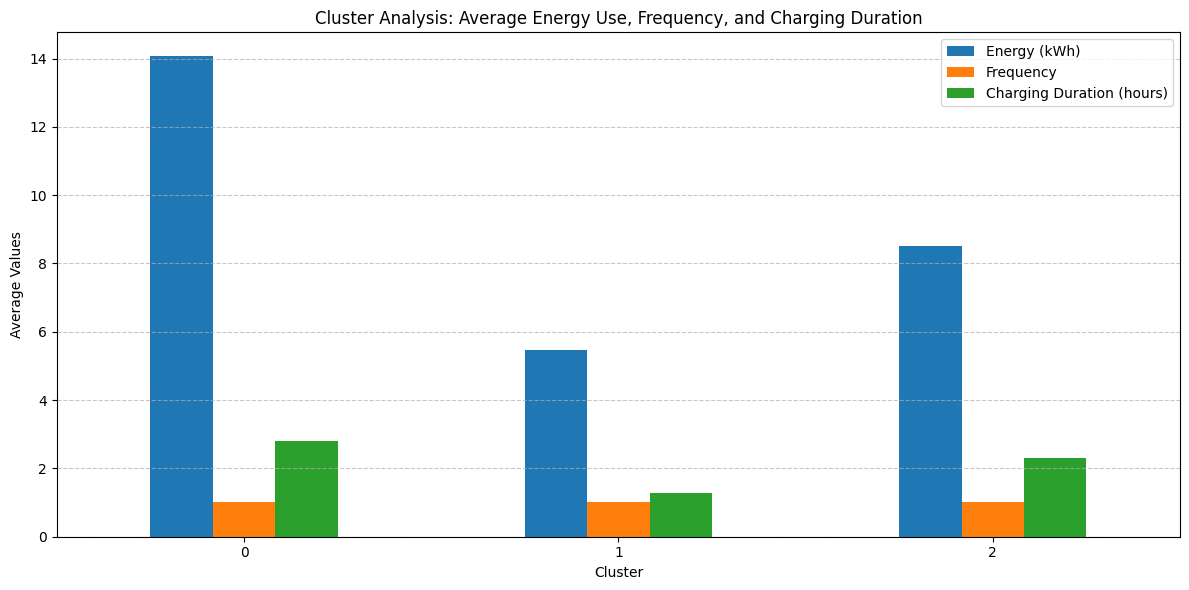

In [34]:
# Visualize the average energy use, charging frequency, and charging duration per cluster
cluster_analysis[['Energy (kWh)', 'Frequency', 'Charging Duration (hours)']].plot(
    kind='bar',
    figsize=(12, 6),
    title='Cluster Analysis: Average Energy Use, Frequency, and Charging Duration',
    ylabel='Average Values',
    xlabel='Cluster'
)

# Adjust layout for better visibility
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

What does this plot tells?
> 

### Visualize Model Number and Port Type Distributions Across Clusters

In [35]:
print(final_clustering_data.columns)
final_clustering_data['Cluster'] = clusters
print(final_clustering_data.head())
# Recreate the cluster-wise aggregation for Model Number and Port Type
model_port_columns = [col for col in final_clustering_data.columns if 'Model_Port' in col]
cluster_model_port_analysis = final_clustering_data.groupby('Cluster')[model_port_columns].mean()

# Confirm the structure again
print(cluster_model_port_analysis.info())
print(cluster_model_port_analysis.head())
print(len(clusters), len(final_clustering_data))
print(clusters[:10])

Index(['Hour', 'Energy (kWh)', 'Frequency', 'Charging Duration (hours)',
       'Level 1', 'Level 2', 'Model_Port_Level 1', 'Model_Port_Level 2'],
      dtype='object')
                                     Hour  Energy (kWh)  Frequency  \
User ID Model Number                                                 
0       Unknown       1350480211926605568      7.074323   1.038991   
102     Unknown       1389279600000000000      8.742773   1.000000   
107     CT4020-HD-GW  1389027927272727296      4.689244   1.000000   
        Unknown       1389027927272727296      4.689244   1.000000   
111     Unknown       1341915882352941056      6.933132   1.117647   

                      Charging Duration (hours)  Level 1  Level 2  \
User ID Model Number                                                
0       Unknown                        2.095372        8      445   
102     Unknown                        2.724583        0        2   
107     CT4020-HD-GW                   1.403712        0        

In [36]:
print(cluster_model_port_analysis.info())  # Inspect the structure
print(cluster_model_port_analysis.head())  # Preview the data
cluster_model_port_analysis = cluster_model_port_analysis.apply(pd.to_numeric, errors='coerce').fillna(0)

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Model_Port_Level 1  3 non-null      float64
 1   Model_Port_Level 2  3 non-null      float64
dtypes: float64(2)
memory usage: 60.0 bytes
None
         Model_Port_Level 1  Model_Port_Level 2
Cluster                                        
0                  0.062598           10.461659
1                  0.048877            3.805465
2                 15.057803          254.728324


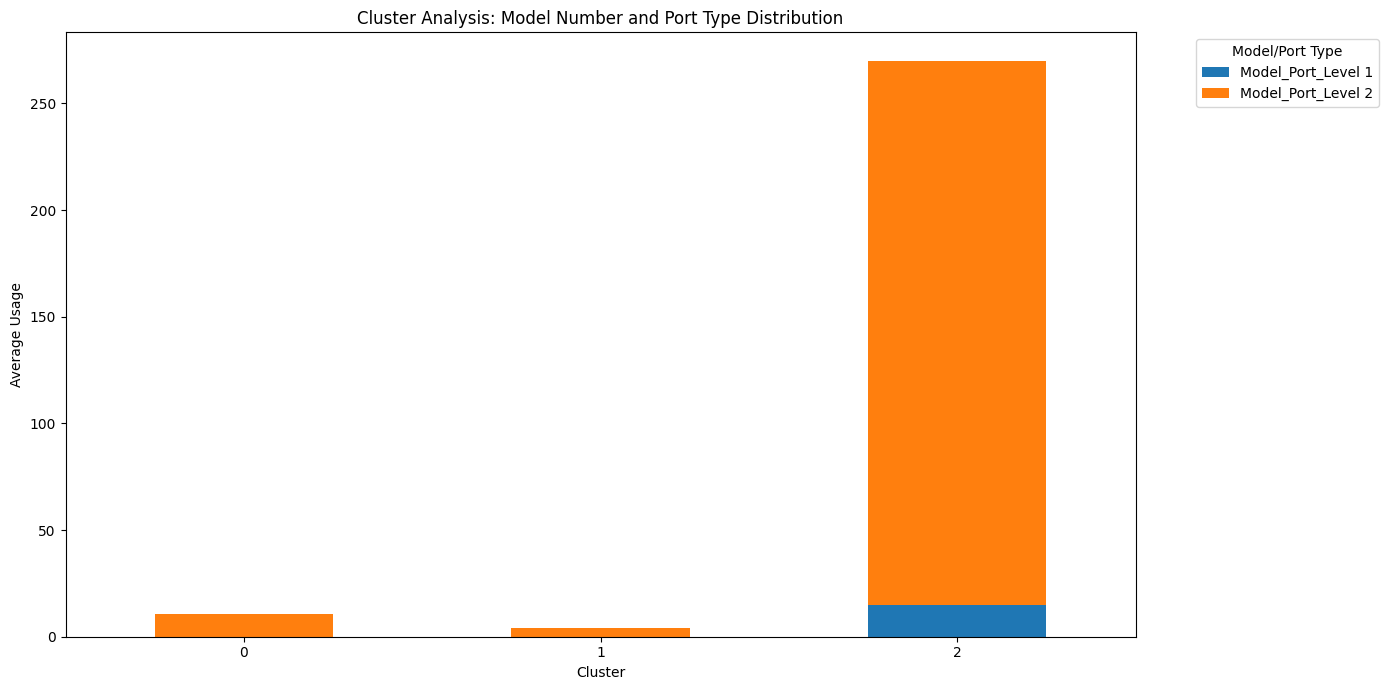

In [37]:
cluster_model_port_analysis.plot(
    kind='bar',
    figsize=(14, 7),
    stacked=True,
    title="Cluster Analysis: Model Number and Port Type Distribution",
    xlabel="Cluster",
    ylabel="Average Usage"
)

plt.xticks(rotation=0)
plt.legend(title="Model/Port Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Aggregate and Summarize Features by Cluster
- Group the dataset by the Cluster column.
- Calculate the mean for all numeric features.
- Display the summary for each cluster.

                 Hour  Energy (kWh)  Frequency  Charging Duration (hours)  \
Cluster                                                                     
0        1.520244e+18     14.064604   1.019443                   2.788292   
1        1.509689e+18      5.473599   1.012404                   1.273133   
2        1.471625e+18      8.512089   1.011069                   2.291109   

           Level 1     Level 2  
Cluster                         
0         0.062598   10.461659  
1         0.048877    3.805465  
2        15.057803  254.728324  


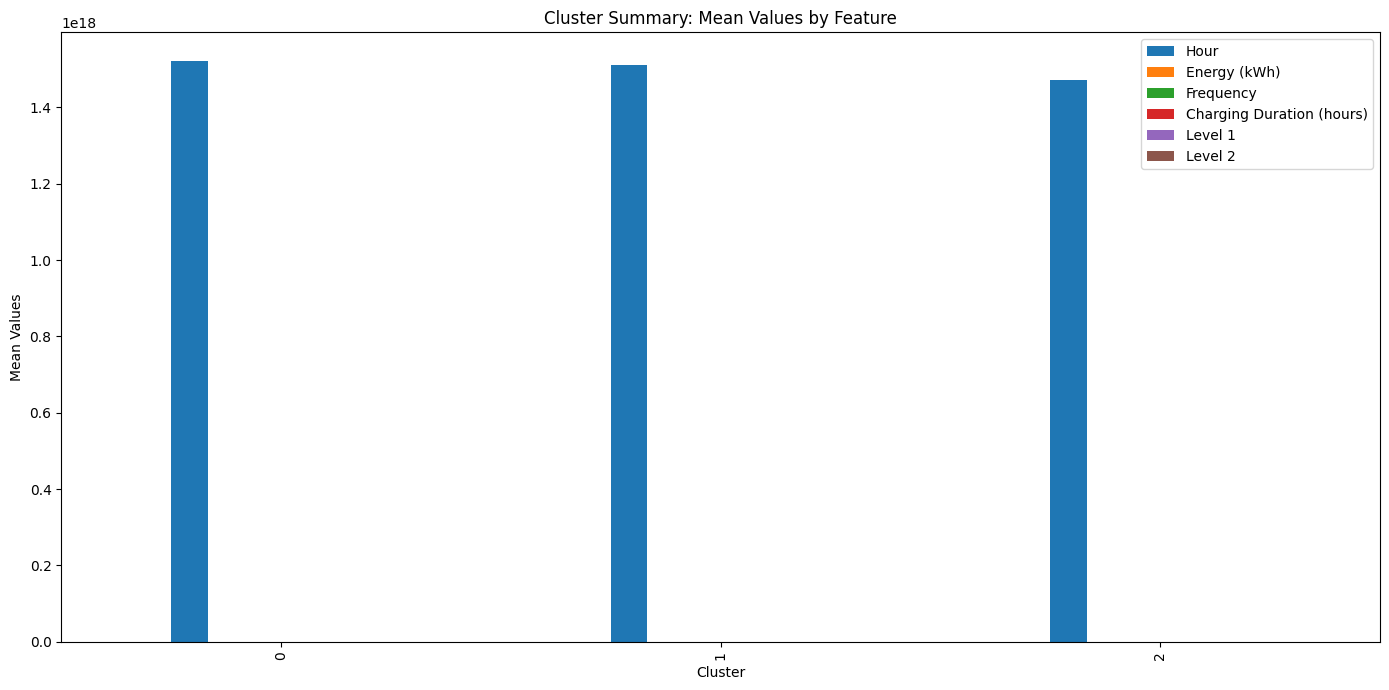

In [38]:
# Aggregate mean values for all features by cluster
cluster_summary = final_clustering_data_cleaned.groupby('Cluster').mean()

# Display the cluster summary
print(cluster_summary)

# Optional: Visualize the summary to understand the differences between clusters
cluster_summary.plot(kind='bar', figsize=(14, 7), title='Cluster Summary: Mean Values by Feature', legend=True)
plt.xlabel('Cluster')
plt.ylabel('Mean Values')
plt.tight_layout()
plt.show()

In [39]:
print("Cluster Summary for Model Number and Port Type (Levels 1 and 2):")
display(cluster_model_port_analysis)

Cluster Summary for Model Number and Port Type (Levels 1 and 2):


,Model_Port_Level 1,Model_Port_Level 2
Cluster,,
0,0.062598,10.461659
1,0.048877,3.805465
2,15.057803,254.728324


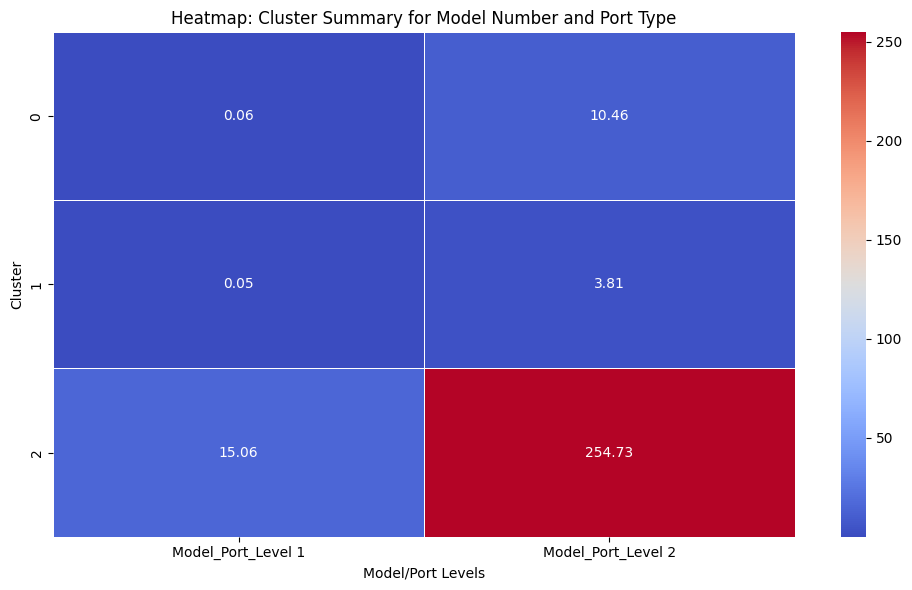

In [40]:
# Create a heatmap to visualize the cluster summary
plt.figure(figsize=(10, 6))
sns.heatmap(
    cluster_model_port_analysis,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
)
plt.title("Heatmap: Cluster Summary for Model Number and Port Type")
plt.xlabel("Model/Port Levels")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

In the context of this heatmap, **clusters** are groups of users created based on similar usage patterns across several features, such as:

1. **Hourly Energy Use** (`Energy (kWh)`),
2. **Charging Frequency**,
3. **Charging Duration (hours)`,
4. **Model Number and Port Type Usage** (`Model_Port_Level 1` and `Model_Port_Level 2`).

### What Does Each Cluster Represent?

The clustering process (e.g., using K-Means) grouped users into three categories (Cluster 0, 1, and 2) based on the similarity of their behaviors:

- **Cluster 0:** Represents users with moderate activity and some preference for `Model_Port_Level 2`. These users are not as infrequent as Cluster 1 but also not as heavy users as Cluster 2.
- **Cluster 1:** Represents the least active users. These users interact minimally with both `Model_Port_Level 1` and `Model_Port_Level 2`.
- **Cluster 2:** Represents the most active and engaged users, especially those who heavily use `Model_Port_Level 2`. These users are likely the ones placing the highest demand on the system.

### How Were the Clusters Defined?
Clusters are defined based on the relationships between features:
1. High `Energy (kWh)`, frequent charging events, and long charging durations are more likely to group users into **Cluster 2**.
2. Sporadic or low interaction with all features results in users being grouped into **Cluster 1**.
3. Intermediate behaviors in all features form **Cluster 0**.

Clusters help identify user behavior patterns within the dataset, such as identifying heavy users, light users, or sporadic users.

### **2: Prediction model**

## **Exploratory Component**
---

### **1: Infrastructure planning**

### **2: Campaigns to increase**

# **Conclusions**
---

# **Word Count**
---

In [41]:
import json

with open('Model_port_type.ipynb') as json_file:
    data = json.load(json_file)

print(data)

{'cells': [{'cell_type': 'code', 'execution_count': 50, 'metadata': {}, 'outputs': [], 'source': ['# Import necessary libraries\n', 'import pandas as pd\n', 'import numpy as np\n', 'import matplotlib.pyplot as plt\n', 'import seaborn as sns\n', 'from sklearn.cluster import KMeans\n', 'from sklearn.preprocessing import StandardScaler\n', 'from sklearn.decomposition import PCA']}, {'cell_type': 'code', 'execution_count': 51, 'metadata': {}, 'outputs': [{'name': 'stderr', 'output_type': 'stream', 'text': ['/var/folders/m7/5qwtqvds6bs3g6xjkfmmxmqr0000gn/T/ipykernel_30521/1789357619.py:3: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.\n', '  data = pd.read_csv(data_path)\n']}], 'source': ['# Load the dataset\n', "data_path = 'EVChargingStationUsage.csv'  # Update this path if needed\n", 'data = pd.read_csv(data_path)']}, {'cell_type': 'code', 'execution_count': 52, 'metadata': {}, 'outputs': [{'data': {'text/html': ['<div>\n', '<st

In [42]:
wordCount = 0
for each in data['cells']:
    cellType = each['cell_type']
    if cellType == "markdown":
        content = each['source']
        for line in content:
            temp = [word for word in line.split() if "#" not in word] # we might need to filter for more markdown keywords here
            wordCount = wordCount + len(temp)
            
print(wordCount)

424


---

Max 2 sider

In [43]:
A4_tegn = 2400
to_sider = A4_tegn * 2
print(to_sider)

4800
